# E1 Simple Matching
Part of the sample study line. The goal of this experiment is to find matching controls for all the subjects with revised ADOS scores.

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Set the paths
full_pheno = '/data1/abide/Pheno/full_merged_pheno.csv'
out_path = '/data1/abide/Pheno/'

In [4]:
pheno = pd.read_csv(full_pheno)
# Create new variable from ratio of VIQ/PIQ
pheno['VPR'] = pheno['VIQ'].values / pheno['PIQ'].values
# get the mask of ados subjects with diagnosis
mask_ados = ~np.isnan(pheno['ADOS_SOCOM_SEV'].values) * pheno['DX_GROUP'].values == 1
# get the mask of ados subjects without diagnosis
mask_ados_control = ~np.isnan(pheno['ADOS_SOCOM_SEV'].values) * pheno['DX_GROUP'].values == 2
# get the mask of control subjects
mask_control = pheno['DX_GROUP'].values == 2 * np.isnan(pheno['ADOS_SOCOM_SEV'].values)
# get the indices of the subjects in the full sample
ados_index = np.where(mask_ados)[0]
control_ados_index = np.where(mask_ados_control)[0]
control_index = np.where(mask_control)[0]
# create the pheno slices
ados = pheno[mask_ados]
control = pheno[mask_control]

## Find closest match
Go through all ADOS subjects and find the closest match. What I am interested in is how often the same control is selected as the best match for an ADOS subject

In [5]:
def find_closest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [6]:
# Find a match and then replace the matched subject
ados_ids = list()
control_ids = list()
ages = pheno['AGE_AT_SCAN'].values

for ados_idx in ados_index:
    target_age = ages[ados_idx]
    # try with the controls that have ADOS
    goon = True
    if control_ados_index.size:
        ados_ages = ages[control_ados_index]
        best_id = find_closest(ados_ages, target_age)
        match_idx = control_ados_index[best_id]
        match_age = ados_ages[best_id]
        dist_age = target_age - match_age
    
        if dist_age < 1:
            # Use this index
            control_ids.append(match_idx)
            control_ados_index = np.delete(control_ados_index, best_id)
            ados_ids.append(ados_idx)
            goon = False

    if goon:
        # Use the other control list
        control_ages = ages[control_index]
        best_id = find_closest(control_ages, target_age)
        match_idx = control_index[best_id]
        match_age = control_ages[best_id]
        dist_age = target_age - match_age
        
        if dist_age < 1:
            control_ids.append(match_idx)
            control_index = np.delete(control_index, best_id)
            ados_ids.append(ados_idx)

In [7]:
ctrl_idx = np.array(control_ids)
ados_idx = np.array(ados_ids)

In [8]:
# Make a combined pheno of both of them
comb_ind = np.append(ctrl_idx, ados_idx)
combined = pheno.iloc[comb_ind]
# And make separate phenos for each of them
ados = pheno.iloc[ados_idx]
ctrl = pheno.iloc[ctrl_idx]

In [9]:
def plot_sample(ados, ctrl):
    ados_grouped = ados.groupby('SITE_ID')
    ctrl_grouped = ctrl.groupby('SITE_ID')
    site_names = ados_grouped.groups.keys()

    ados_ages = [ados_grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    ados_dx = [ados_grouped.get_group(st)['DX_GROUP'].values for st in site_names]

    ctrl_ages = [ctrl_grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    ctrl_dx = [ctrl_grouped.get_group(st)['DX_GROUP'].values for st in site_names]


    f = plt.figure(figsize=(10,4))
    ax = f.add_subplot(111)
    y_ados = np.array([])
    x_ados = np.array([])
    y_ctrl = np.array([])
    x_ctrl = np.array([])

    for idx, ados_ag in enumerate(ados_ages):
        # ados first
        l_ages = len(ados_ag)
        ind = np.ones((l_ages,))*idx+1
        jitter = (np.random.random(l_ages,)*2-1)*0.2
        ind += jitter

        x_ados = np.append(x_ados, ind)
        y_ados = np.append(y_ados, ados_ag)

        # now ctrl
        ctrl_ag = ctrl_ages[idx]
        l_ages = len(ctrl_ag)
        ind = np.ones((l_ages,))*idx+1
        jitter = (np.random.random(l_ages,)*2-1)*0.2
        ind += jitter

        x_ctrl = np.append(x_ctrl, ind)
        y_ctrl = np.append(y_ctrl, ctrl_ag)

    ad = ax.scatter(x_ados, y_ados, c='r', alpha=0.5)
    ct = ax.scatter(x_ctrl, y_ctrl, c='y', alpha=0.5)
    ax.legend((ad, ct),
               ('Patient', 'Control'),
               scatterpoints=1,
               loc='upper right',
               ncol=1,
               fontsize=10)
    tmp = ax.set_xticks(np.arange(len(site_names))+1)
    tmp = ax.set_xticklabels(site_names, rotation=70)
    tmp = ax.set_ylabel('Age')
    tmp = ax.set_title('Simple Matching ADOS sample')

## Look at the sample

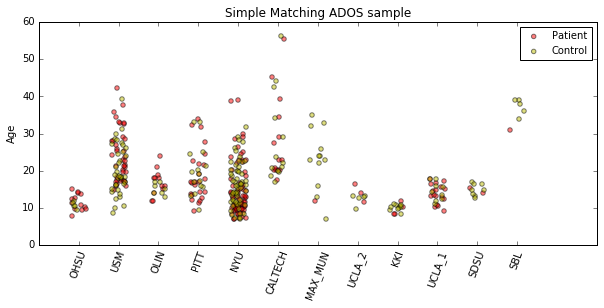

In [10]:
plot_sample(ados, ctrl)

This is not ideal. There is a strong site bias regarding the ratio of patients/controls. Some sites also provide almost nothing to the sample. And then there is a wide age spread. So there are some constraints we can implement:

- exclude all sites with < x number of subjects
- fix the ratio of control / patient
- limit the age range to something below 20/30 (UCLA has too few to otherwise be included)

## Constrained sample

In [11]:
# Check the number of subjects
all_grouped = combined.groupby('SITE_ID')

for x in all_grouped:
    print('{1} subjects in {0}'.format(x[0], len(x[1])))

27 subjects in CALTECH
6 subjects in CMU
14 subjects in KKI
8 subjects in LEUVEN_2
13 subjects in MAX_MUN
130 subjects in NYU
18 subjects in OHSU
19 subjects in OLIN
39 subjects in PITT
6 subjects in SBL
10 subjects in SDSU
6 subjects in STANFORD
26 subjects in UCLA_1
8 subjects in UCLA_2
76 subjects in USM


Ok, looks like we can go with these sites:
- USM
- PITT
- NYU
- UCLA combined

In [12]:
include = ['USM', 'PITT', 'NYU', 'UCLA_1', 'UCLA_2']
site_constrained = combined[combined['SITE_ID'].isin(include)]

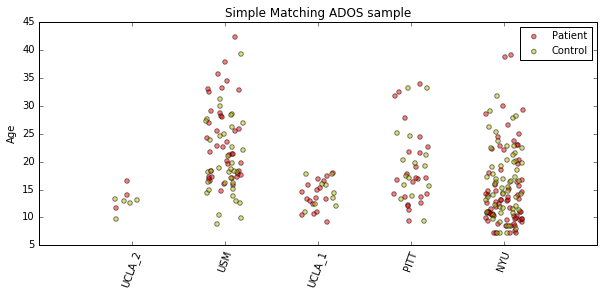

In [13]:
# Split it into control and patient to get a look
site_patient = site_constrained[site_constrained['DX_GROUP'] == 1]
site_control = site_constrained[site_constrained['DX_GROUP'] == 2]
plot_sample(site_patient, site_control)

Doesn't look so bad, but still a site * age interaction. If we cap at 20, what happens?

In [14]:
age_constrained = site_constrained[site_constrained['AGE_AT_SCAN'] < 20]

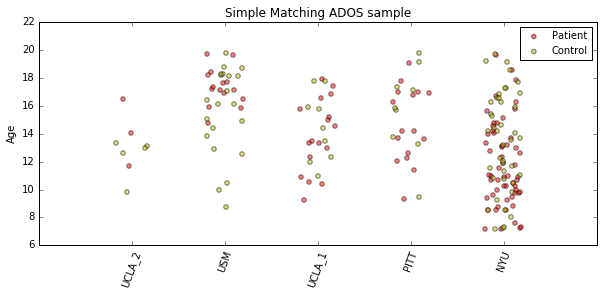

In [15]:
# Split it up and look at the sample
age_patient = age_constrained[age_constrained['DX_GROUP'] == 1]
age_control = age_constrained[age_constrained['DX_GROUP'] == 2]
plot_sample(age_patient, age_control)

Fair enough, I would say. Not ideal certainly but good enough. Let's look at the ratio of patient / control

In [16]:
len(age_patient)

108

In [17]:
len(age_control)

86

Alright. I take this as the most constrained and cleanest sample. So now we have a number of samples, let's save them all

In [18]:
len(combined)

406

In [19]:
len(site_constrained)

279

In [20]:
len(age_constrained)

194

In [21]:
# Save them to disk
combined.to_csv(os.path.join(out_path, 'combined_406.csv'), index=False)
site_constrained.to_csv(os.path.join(out_path, 'site_balanced_279.csv'), index=False)
age_constrained.to_csv(os.path.join(out_path, 'site_and_age_balanced_194.csv'), index=False)